In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def test_file(i: int):
    return f'images/feedback({i}).jpg'

In [34]:
def display_image(image, title="Image", cmap=None):
    plt.figure(figsize=(10, 10))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

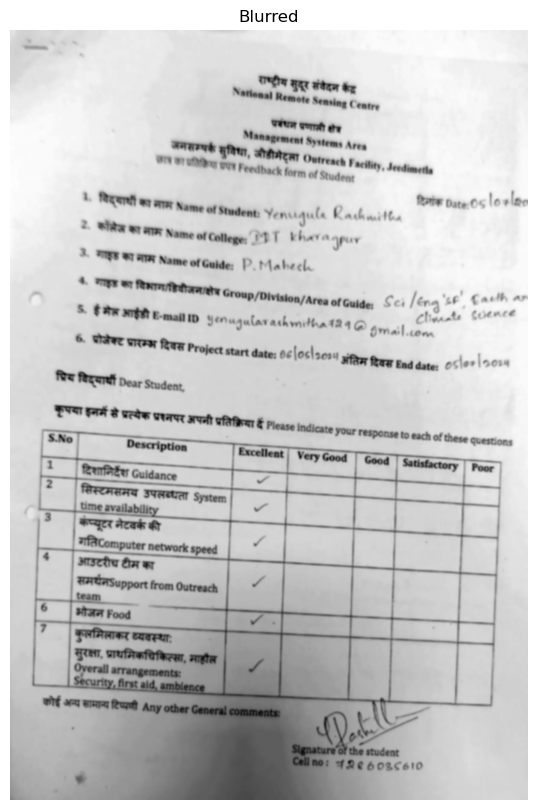

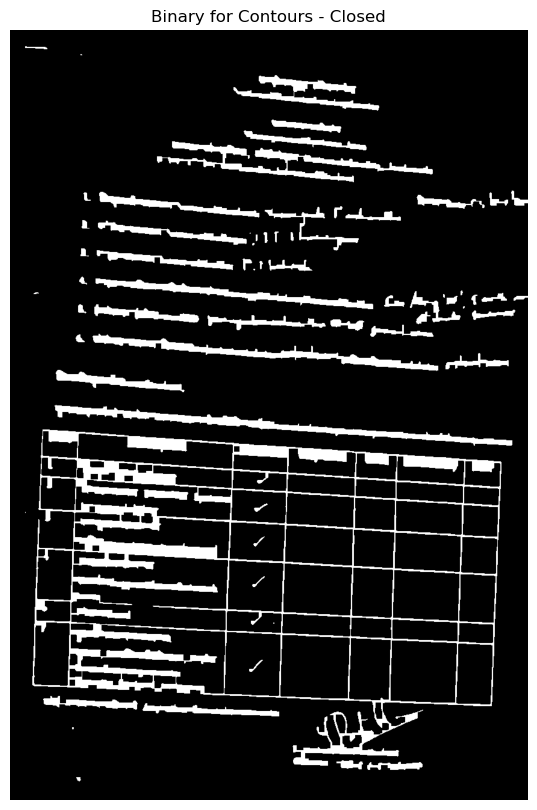

In [39]:
# for i in range(2, 6):
image_path = test_file(2)
original_image = cv2.imread(image_path)
if original_image is None:
    print(f"Error: Could not load image at {image_path}")
    exit()
        
img_height, img_width = original_image.shape[:2]
gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
# display_image(gray, "Grayscale", cmap='gray')

# Blur to reduce noise and help contour detection
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
# display_image(blurred, "Blurred", cmap='gray')

# Binarize: Adaptive thresholding is good for varying lighting/contrast
# We want table lines to be black on white for contour finding or white on black for line extraction
# For contour finding of the table boundary, let's try to get black lines on white background
binary_for_contours = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 31, 20 # Block size, C value - TUNE THESE
)
# display_image(binary_for_contours, "Binary for Contours", cmap='gray')

# Optional: Morphological operations to close gaps in table borders if necessary
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
binary_for_contours = cv2.morphologyEx(binary_for_contours, cv2.MORPH_CLOSE, kernel, iterations=2)
display_image(binary_for_contours, "Binary for Contours - Closed", cmap='gray')

No potential table contours found. Try adjusting preprocessing or contour filtering.


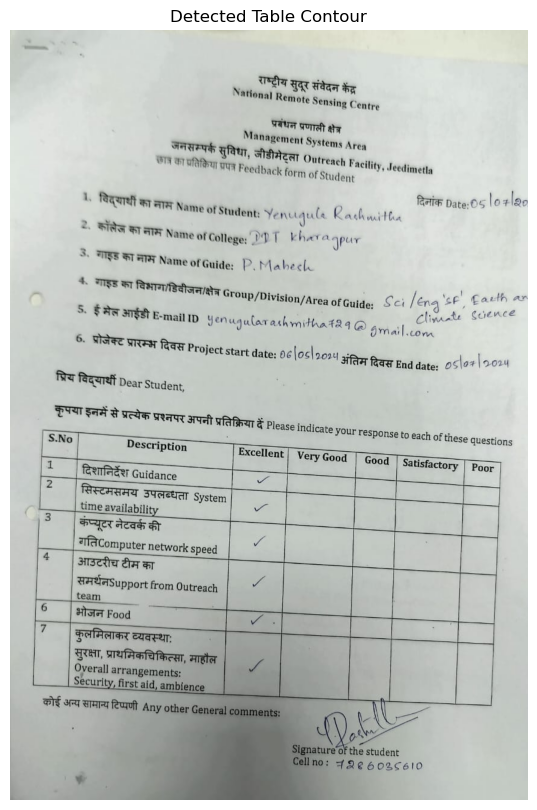

In [38]:
contours, hierarchy = cv2.findContours(binary_for_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours to find the table
# Criteria: Area, Aspect Ratio, Number of vertices (should be ~4 for a rectangle)
possible_tables = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area < (img_width * img_height * 0.05) or area > (img_width * img_height * 0.8): # Min/Max area
        continue

    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True) # 0.02 is a common factor

    if len(approx) == 4: # Should be a quadrilateral
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        # Add more specific aspect ratio constraints if needed
        # e.g. if aspect_ratio > 0.5 and aspect_ratio < 3:
        if w > img_width * 0.3 and h > img_height * 0.1: # Min width and height
            possible_tables.append({
                'contour': approx,
                'area': area,
                'bbox': (x, y, w, h)
            })

if not possible_tables:
    print("No potential table contours found. Try adjusting preprocessing or contour filtering.")
    # Fallback: use the whole image, or a manually defined region if necessary
    table_roi = original_image.copy()
    table_bbox = (0,0, img_width, img_height)
else:
    # Sort by area (largest first) or y-coordinate (to get lower tables)
    # For this image, the table is quite large and distinct.
    possible_tables = sorted(possible_tables, key=lambda x: x['area'], reverse=True)
    best_table_contour = possible_tables[0]['contour']
    table_bbox = possible_tables[0]['bbox']
    x, y, w, h = table_bbox

    # Crop the original image to get the Table ROI
    table_roi = original_image[y:y+h, x:x+w]
    print(f"Table ROI extracted at: x={x}, y={y}, w={w}, h={h}")
    display_image(table_roi, "Isolated Table ROI")

# --- Debug: Draw the detected table contour on the original image ---
debug_image_contours = original_image.copy()
if possible_tables:
     cv2.drawContours(debug_image_contours, [best_table_contour], -1, (0,255,0), 3)
display_image(debug_image_contours, "Detected Table Contour")

In [7]:
gray_image = grayscale(test)
cv2.imwrite('images/gray_test.jpg', gray_image)

True

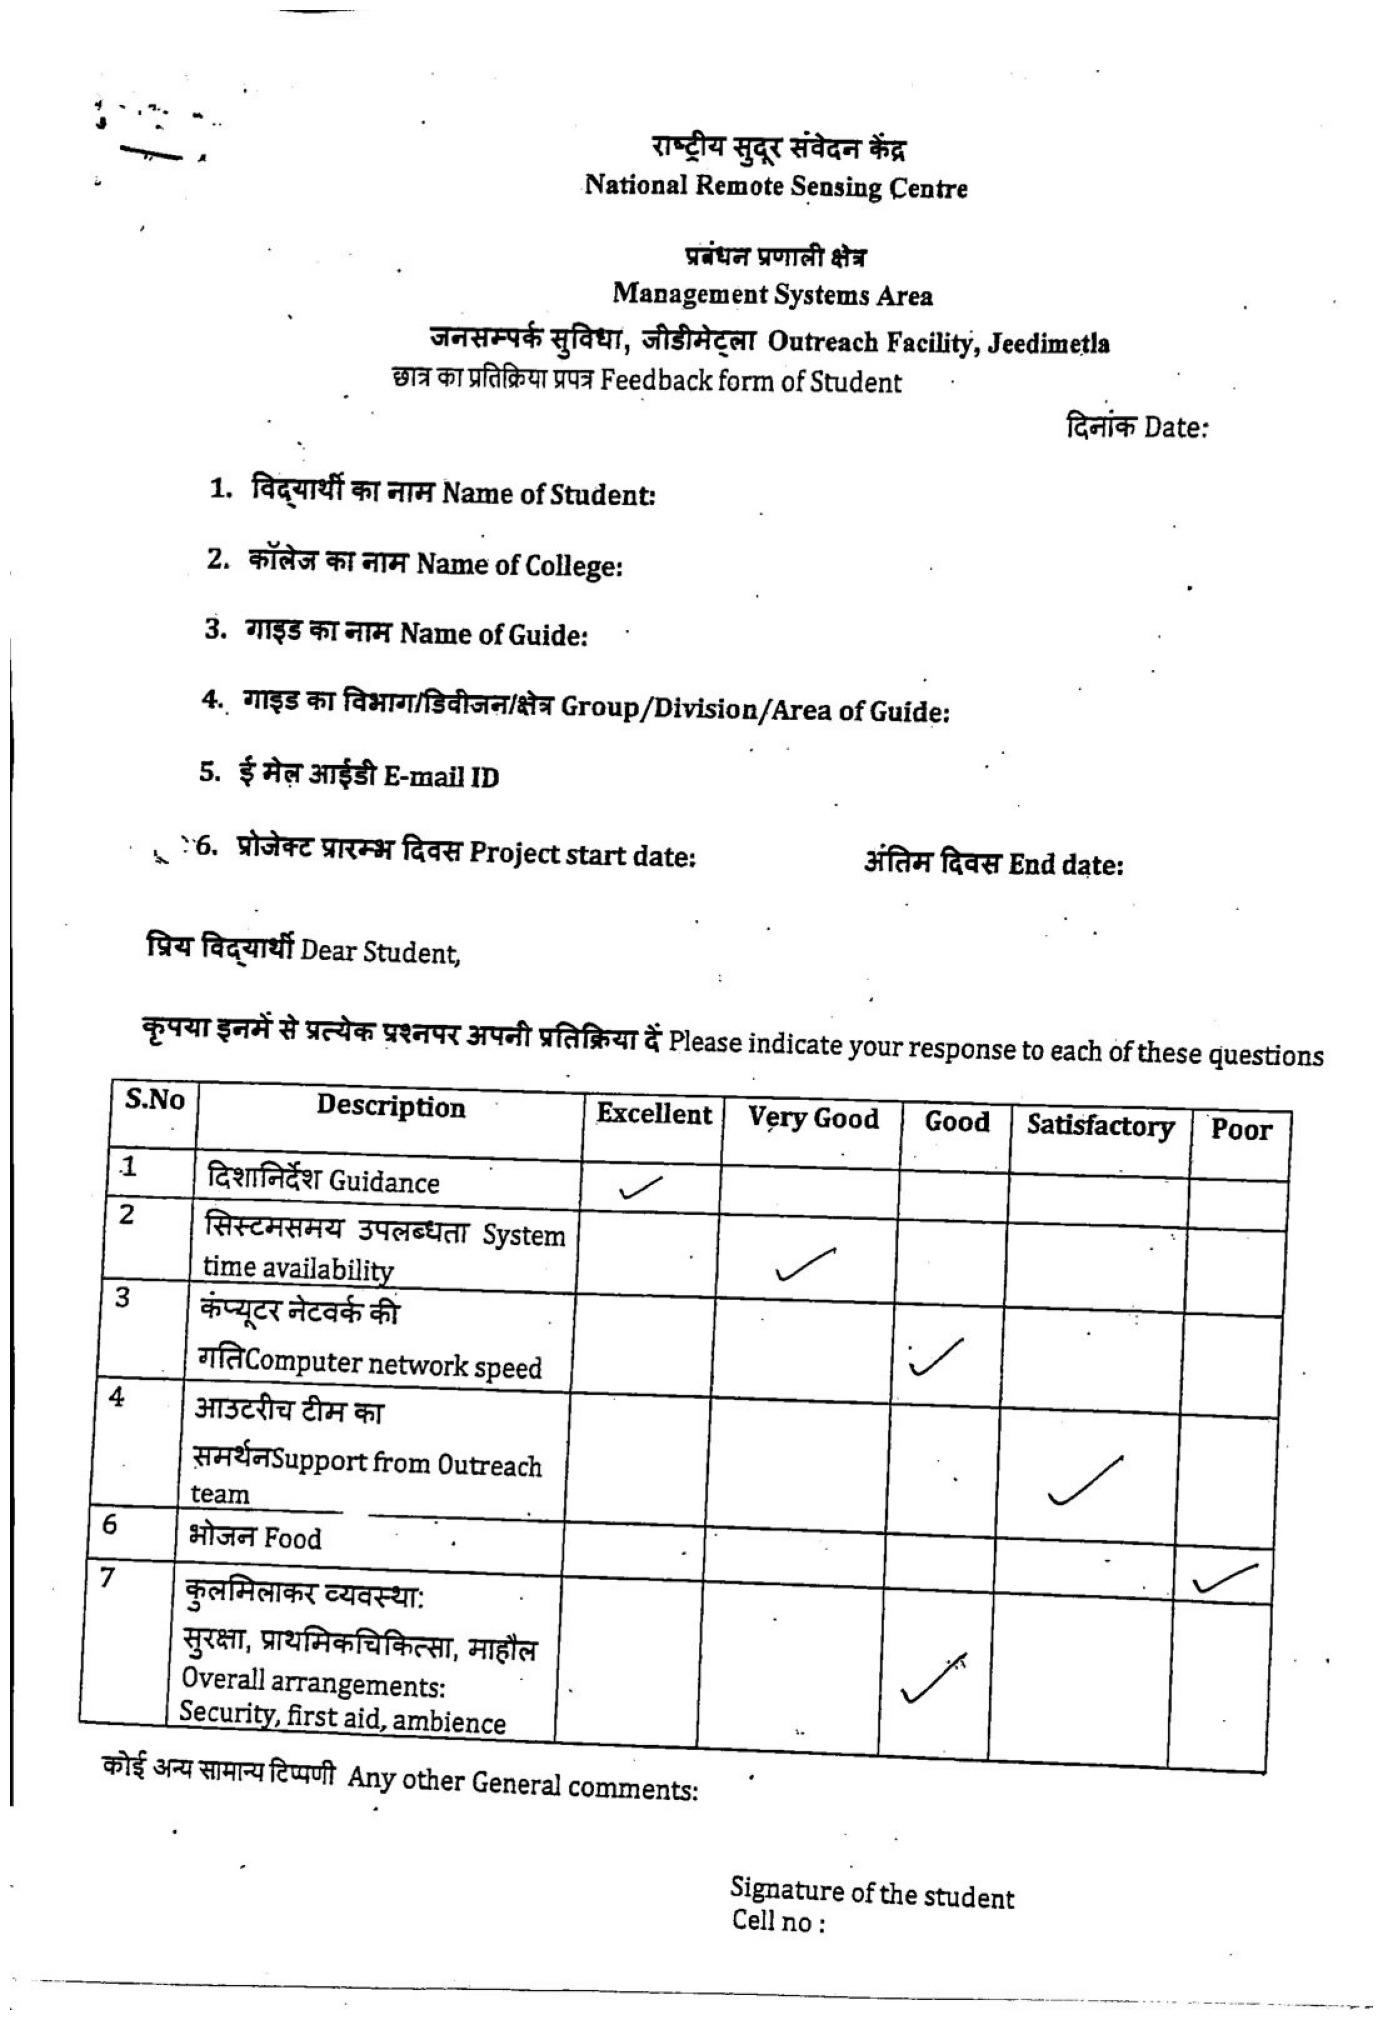

In [8]:
display('images/gray_test.jpg')

In [9]:
thresh, im_bw = cv2.threshold(gray_image, 190, 230, cv2.THRESH_BINARY)
cv2.imwrite('images/bw_image_test.jpg', im_bw)

True

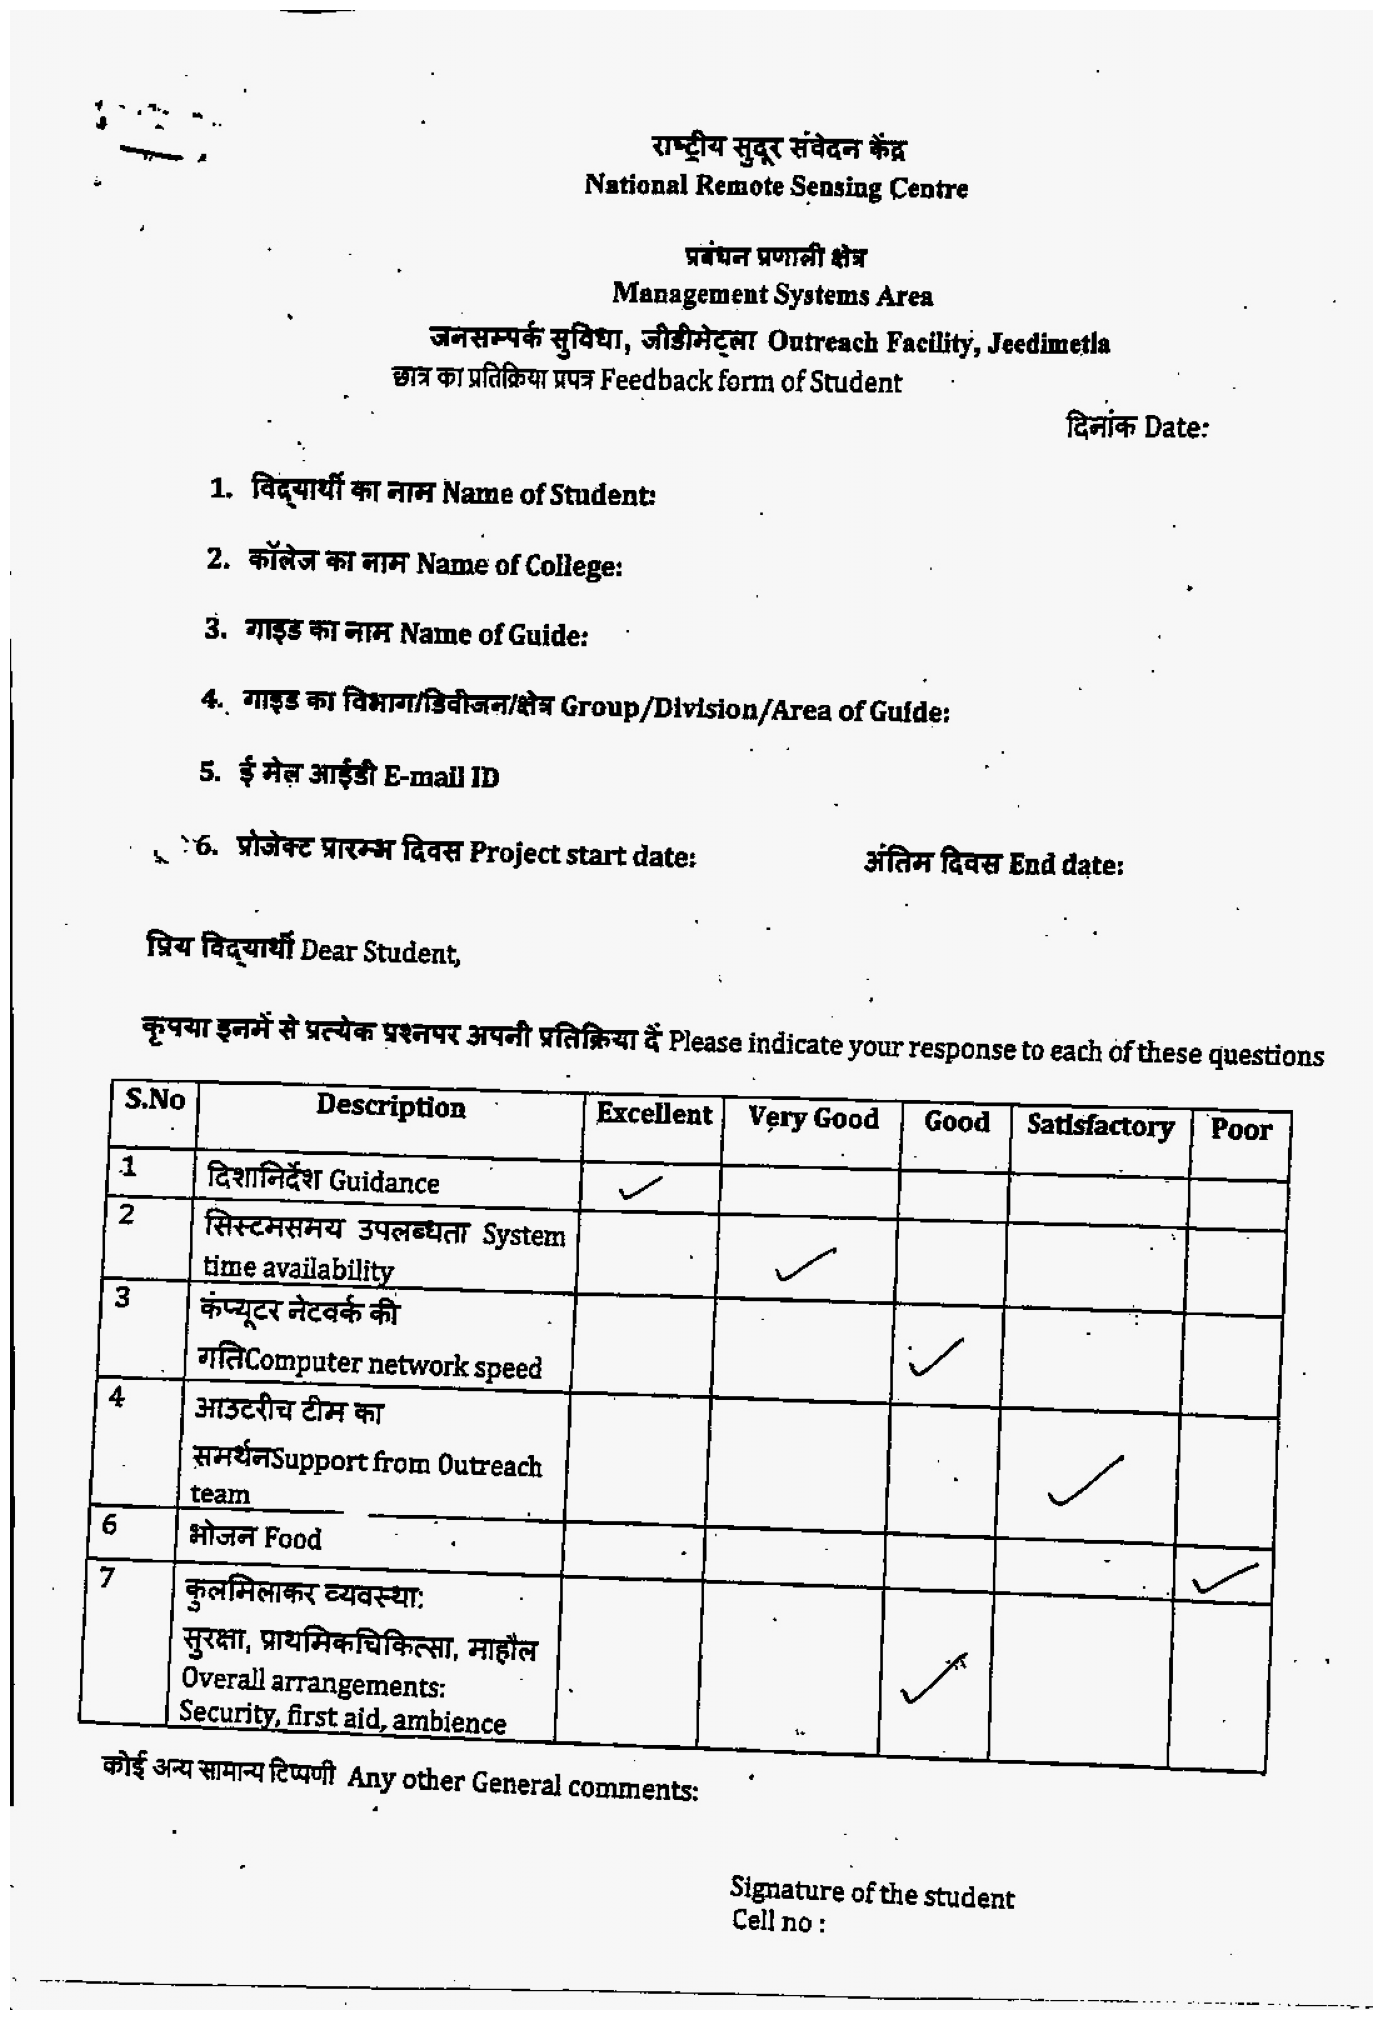

In [10]:
display('images/bw_image_test.jpg')

In [12]:
def getSkewAngle(cvImage) -> float:
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations = 2)

    contours, heirarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x, y, w, h = rect
        cv2.rectangle(newImage, (x, y), (x + w, y + h), (0, 255, 0), 2)

    largestContour = contours[0]
    print(len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite('images/boxes_test.jpg', newImage)
    angle = minAreaRect[-1]
    if angle < -45:
        angle += 90
    return -1.0 * angle

def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [13]:
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [14]:
fixed = deskew(test)
cv2.imwrite('images/rotated_test.jpg', fixed)

104


True

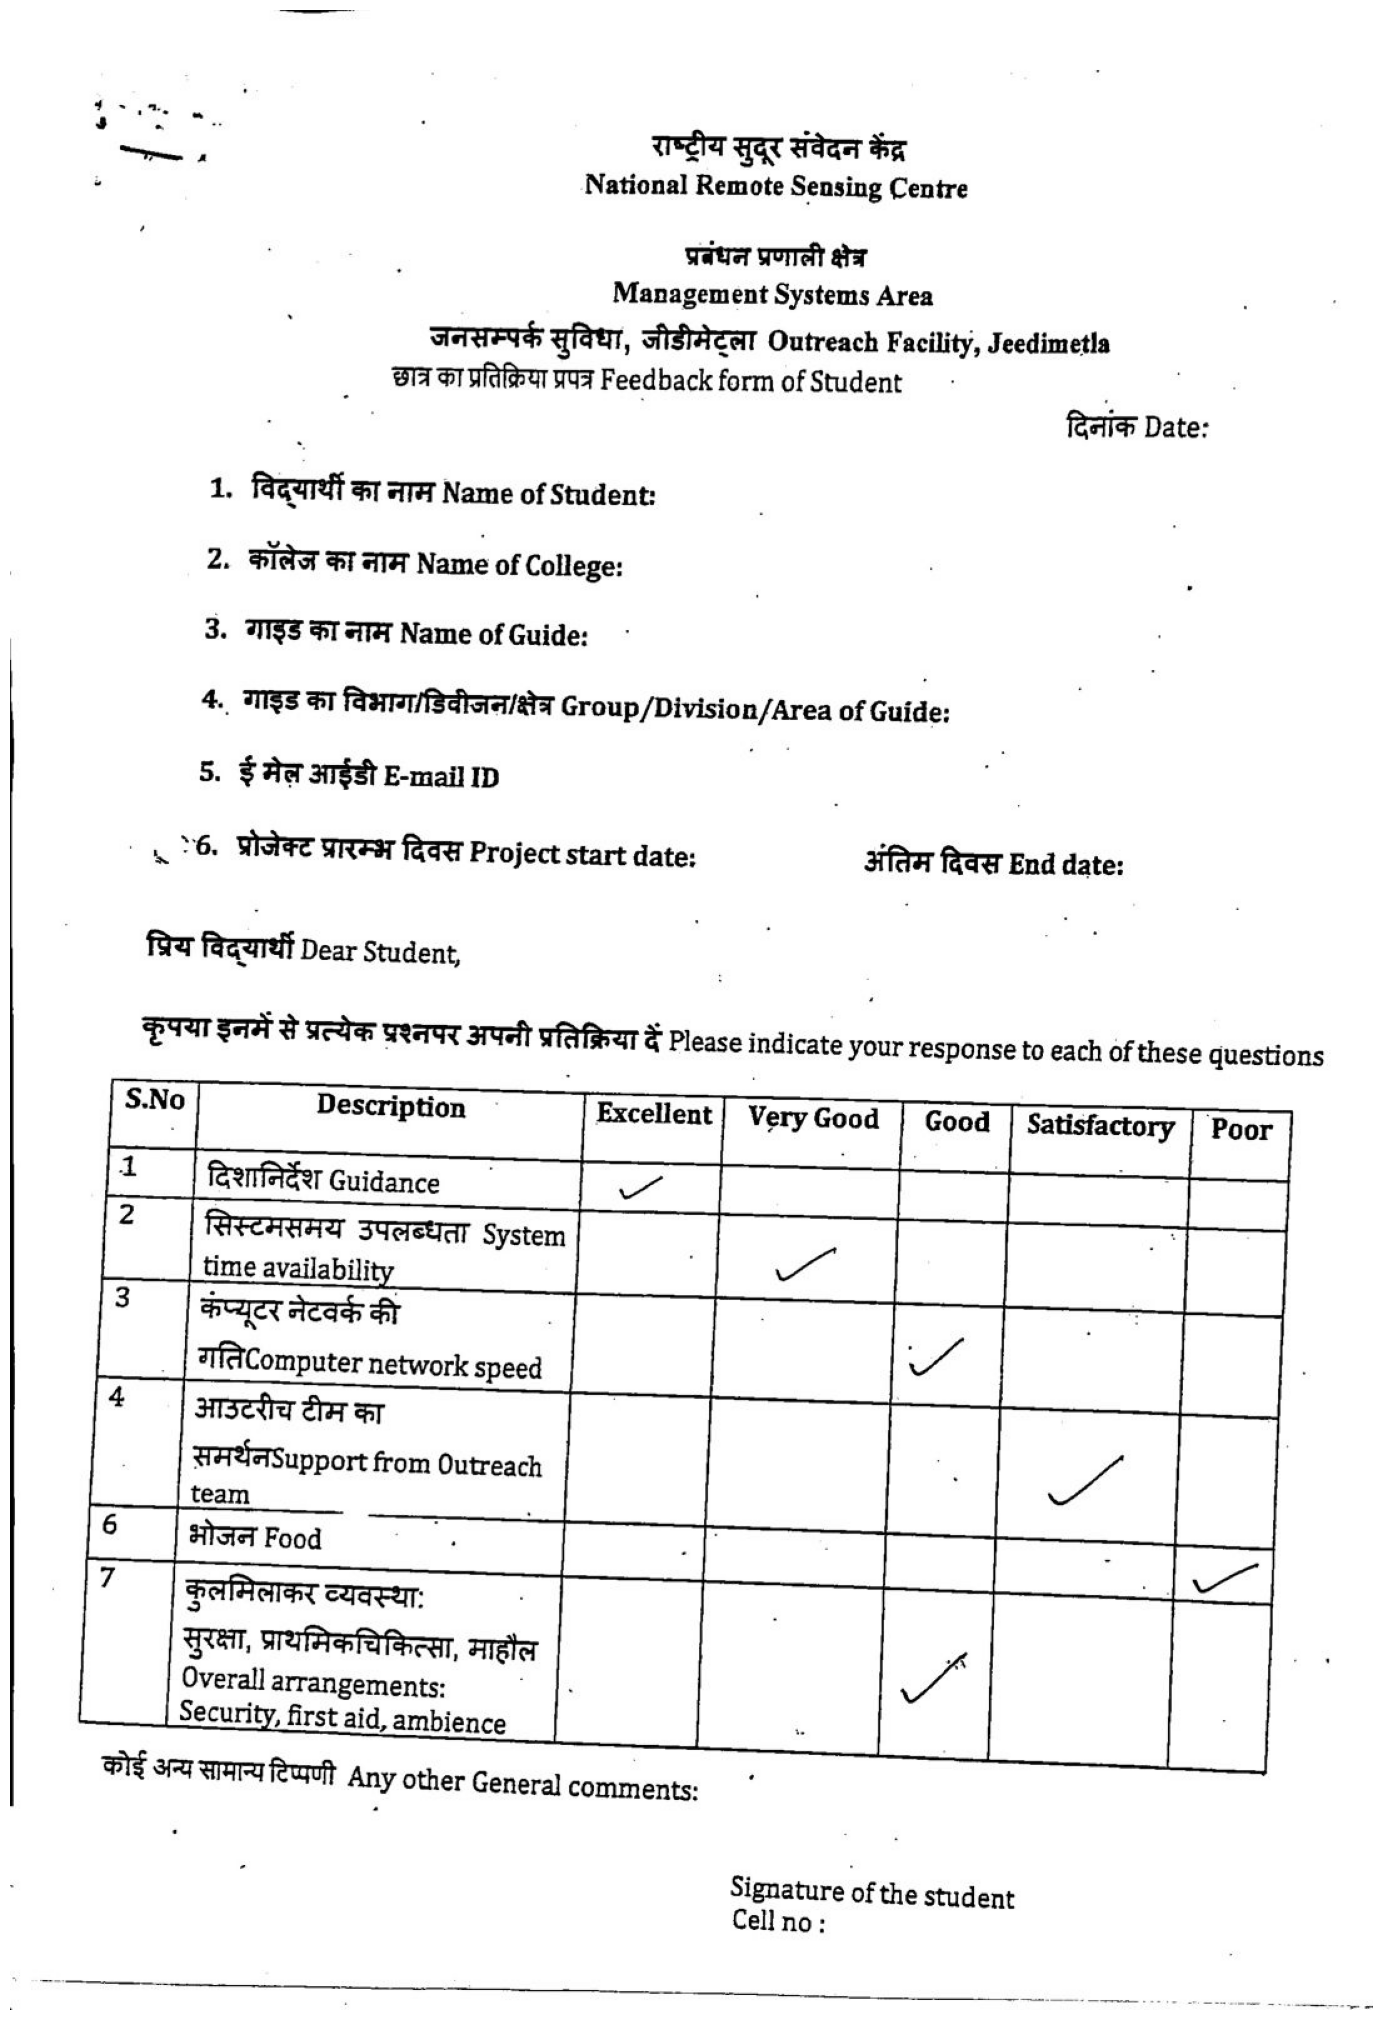

In [15]:
display('images/rotated_test.jpg')

In [17]:
img_height, img_width, img_channels = test.shape

In [19]:
# For Horizontal Lines
horizontal_kernel_len = max(15, img_width // 30) # Rule of thumb, adjust
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_kernel_len, 1))
img_temp_h = cv2.erode(im_bw, horizontal_kernel, iterations=1) # Erode to remove non-horizontal elements
horizontal_lines_img = cv2.dilate(img_temp_h, horizontal_kernel, iterations=1) # Dilate to restore horizontal lines

# cv2.imshow("Horizontal Lines Enhanced", horizontal_lines_img)
# cv2.waitKey(0)

# For Vertical Lines
vertical_kernel_len = max(15, img_height // 30) # Rule of thumb, adjust
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_kernel_len))
img_temp_v = cv2.erode(im_bw, vertical_kernel, iterations=1)
vertical_lines_img = cv2.dilate(img_temp_v, vertical_kernel, iterations=1)

# cv2.imshow("Vertical Lines Enhanced", vertical_lines_img)
# cv2.waitKey(0)

# --- Now apply HoughLinesP to these enhanced images ---
# Parameters for HoughLinesP:
# image: Input binary image.
# rho: Distance resolution of the accumulator in pixels. (1 is good)
# theta: Angle resolution of the accumulator in radians. (np.pi / 180 for 1 degree)
# threshold: Accumulator threshold parameter. Only lines that get enough votes are returned. (Tune this)
# minLineLength: Minimum line length. Shorter lines are discarded. (Tune this)
# maxLineGap: Maximum allowed gap between points on the same line to link them. (Tune this)

rho = 1
theta = np.pi / 180
threshold_h = 50 # Tune
min_line_length_h = img_width // 10 # Tune, e.g., line must be at least 1/10 of image width
max_line_gap_h = 5 # Tune

threshold_v = 50 # Tune
min_line_length_v = img_height // 10 # Tune, e.g., line must be at least 1/10 of image height
max_line_gap_v = 5 # Tune

h_lines = cv2.HoughLinesP(horizontal_lines_img, rho, theta, threshold_h,
                          minLineLength=min_line_length_h, maxLineGap=max_line_gap_h)

v_lines = cv2.HoughLinesP(vertical_lines_img, rho, theta, threshold_v,
                          minLineLength=min_line_length_v, maxLineGap=max_line_gap_v)

In [20]:
print(h_lines)
print(v_lines)

[[[ 950  329 1089  190]]

 [[ 419  808  658  569]]

 [[ 544  891  730 1077]]

 ...

 [[1045  889 1046  999]]

 [[1057  938 1059 1108]]

 [[1035 1306 1038 1117]]]
[[[ 823  268 1089    2]]

 [[ 734  673  818  275]]

 [[  36 1575   36    0]]

 ...

 [[  83  854   83  603]]

 [[1051  765 1056  461]]

 [[  23  665   23   99]]]


In [21]:
def average_lines(lines, orientation='horizontal', tolerance=10):
    if lines is None or len(lines) == 0:
        return []

    if orientation == 'horizontal':
        # Group lines by their y-coordinate
        lines = sorted(lines, key=lambda line: line[0][1]) # Sort by y1
        avg_lines = []
        current_group = [lines[0]]
        for i in range(1, len(lines)):
            # Check if y1 of current line is close to y1 of first line in group
            if abs(lines[i][0][1] - current_group[0][0][1]) < tolerance:
                current_group.append(lines[i])
            else:
                # Average the current group
                y_coords = [l[0][1] for l in current_group] + [l[0][3] for l in current_group]
                avg_y = int(np.mean(y_coords))
                x_coords = [l[0][0] for l in current_group] + [l[0][2] for l in current_group]
                min_x = min(x_coords)
                max_x = max(x_coords)
                avg_lines.append([[min_x, avg_y, max_x, avg_y]]) # Create a single representative line
                current_group = [lines[i]]
        # Average the last group
        y_coords = [l[0][1] for l in current_group] + [l[0][3] for l in current_group]
        avg_y = int(np.mean(y_coords))
        x_coords = [l[0][0] for l in current_group] + [l[0][2] for l in current_group]
        min_x = min(x_coords)
        max_x = max(x_coords)
        avg_lines.append([[min_x, avg_y, max_x, avg_y]])
        return avg_lines
    else: # Vertical
        lines = sorted(lines, key=lambda line: line[0][0]) # Sort by x1
        avg_lines = []
        current_group = [lines[0]]
        for i in range(1, len(lines)):
            if abs(lines[i][0][0] - current_group[0][0][0]) < tolerance:
                current_group.append(lines[i])
            else:
                x_coords = [l[0][0] for l in current_group] + [l[0][2] for l in current_group]
                avg_x = int(np.mean(x_coords))
                y_coords = [l[0][1] for l in current_group] + [l[0][3] for l in current_group]
                min_y = min(y_coords)
                max_y = max(y_coords)
                avg_lines.append([[avg_x, min_y, avg_x, max_y]])
                current_group = [lines[i]]
        x_coords = [l[0][0] for l in current_group] + [l[0][2] for l in current_group]
        avg_x = int(np.mean(x_coords))
        y_coords = [l[0][1] for l in current_group] + [l[0][3] for l in current_group]
        min_y = min(y_coords)
        max_y = max(y_coords)
        avg_lines.append([[avg_x, min_y, avg_x, max_y]])
        return avg_lines

# Refine detected lines
refined_h_lines = average_lines(h_lines, orientation='horizontal', tolerance=10) # Tune tolerance
refined_v_lines = average_lines(v_lines, orientation='vertical', tolerance=10)   # Tune tolerance

# --- Visualization of Refined Lines (Optional) ---
# line_image = np.copy(original_image) * 0 # Black image
# for line_group in [refined_h_lines, refined_v_lines]:
#     if line_group:
#         for line in line_group:
#             x1, y1, x2, y2 = line[0]
#             cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2) # Draw green lines
# cv2.imshow("Refined Lines", line_image)
# cv2.waitKey(0)

# Extract just the y-coordinates for horizontal lines and x-coordinates for vertical lines
horizontal_y_coords = sorted(list(set([line[0][1] for line in refined_h_lines if line])))
vertical_x_coords = sorted(list(set([line[0][0] for line in refined_v_lines if line])))

# --- Add image boundaries if they weren't detected as lines ---
# This ensures you get cells up to the edges of the image/table
# For horizontal lines (y-coordinates)
if not horizontal_y_coords or horizontal_y_coords[0] > 10: # If first line is far from top
    horizontal_y_coords.insert(0, 0)
if not horizontal_y_coords or horizontal_y_coords[-1] < img_height - 10: # If last line far from bottom
    horizontal_y_coords.append(img_height -1)

# For vertical lines (x-coordinates)
if not vertical_x_coords or vertical_x_coords[0] > 10:
    vertical_x_coords.insert(0, 0)
if not vertical_x_coords or vertical_x_coords[-1] < img_width - 10:
    vertical_x_coords.append(img_width -1)

# Remove very close coordinates again after adding boundaries (can happen if a detected line is at border)
def remove_close_coords(coords, min_dist=10):
    if not coords: return []
    unique_coords = [coords[0]]
    for i in range(1, len(coords)):
        if abs(coords[i] - unique_coords[-1]) >= min_dist:
            unique_coords.append(coords[i])
    return unique_coords

horizontal_y_coords = remove_close_coords(sorted(list(set(horizontal_y_coords))), min_dist=10) # Tune min_dist
vertical_x_coords = remove_close_coords(sorted(list(set(vertical_x_coords))), min_dist=10)

In [23]:
cell_rois_coords = [] # List to store (x, y, w, h) for each cell
cell_images = []      # List to store the cropped cell images

if len(horizontal_y_coords) < 2 or len(vertical_x_coords) < 2:
    print("Not enough horizontal or vertical lines detected to form cells.")
else:
    for i in range(len(horizontal_y_coords) - 1):
        y1 = horizontal_y_coords[i]
        y2 = horizontal_y_coords[i+1]
        row_height = y2 - y1
        if row_height < 10: continue # Skip very thin rows (likely artifacts)

        for j in range(len(vertical_x_coords) - 1):
            x1 = vertical_x_coords[j]
            x2 = vertical_x_coords[j+1]
            col_width = x2 - x1
            if col_width < 10: continue # Skip very thin columns

            cell_bbox = (x1, y1, col_width, row_height)
            cell_rois_coords.append({
                "bbox": cell_bbox,
                "row": i,
                "col": j
            })

            # Extract the cell ROI from the ORIGINAL image or a preprocessed one suitable for tick detection
            # Using grayscale image for consistency, but original_image might be better if color matters for ticks
            cell_image_roi = gray_image[y1:y2, x1:x2] # Or use original_image
            cell_images.append({
                "image": cell_image_roi,
                "row": i,
                "col": j,
                "bbox_original": (x1, y1, x2, y2) # x_min, y_min, x_max, y_max
            })

            # --- Optional: Draw detected cells on a copy of the image ---
            # cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 0, 255), 1) # Red rectangles

# cv2.imshow("Detected Cells", original_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [24]:
print(f"Detected {len(cell_images)} potential cells.")

# Example: Access the first detected cell's image
# if cell_images:
#     first_cell_info = cell_images[0]
#     cv2.imshow(f"Cell (Row {first_cell_info['row']}, Col {first_cell_info['col']})", first_cell_info['image'])
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

Detected 5110 potential cells.


In [28]:
# Assume original_image is loaded
# Assume cell_images is a list of dicts, each with 'bbox_original': (x_min, y_min, x_max, y_max)
# or cell_rois_coords is a list of dicts, each with 'bbox': (x, y, w, h) and 'row', 'col'

image_with_cells = test.copy() # Work on a copy

# If using cell_images (which has absolute coordinates x_min, y_min, x_max, y_max)
for cell_info in cell_images: # Assuming cell_images is populated as in my Option 2A example
    x1, y1, x2, y2 = cell_info['bbox_original']
    row = cell_info['row']
    col = cell_info['col']

    # Draw the rectangle
    cv2.rectangle(image_with_cells, (x1, y1), (x2, y2), (0, 0, 255), 2) # Red, thickness 2

    # Optional: Put text (row, col) for easier debugging
    label = f"R{row}C{col}"
    cv2.putText(image_with_cells, label, (x1 + 5, y1 + 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1) # Blue text

# Or, if using cell_rois_coords (which has x, y, w, h)
# for cell_data in cell_rois_coords:
#     x, y, w, h = cell_data['bbox']
#     row = cell_data['row']
#     col = cell_data['col']
#     cv2.rectangle(image_with_cells, (x, y), (x + w, y + h), (0, 0, 255), 2)
#     label = f"R{row}C{col}"
#     cv2.putText(image_with_cells, label, (x + 5, y + 15),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)


# Display the image
cv2.imshow("Detected Cells Verification", image_with_cells)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Or save it to a file for closer inspection
# cv2.imwrite("detected_cells_verification.png", image_with_cells)

In [29]:
# Assuming cell_images is populated
# Display, for example, the first 5 cell ROIs
for i, cell_info in enumerate(cell_images[:5]):
    cell_roi_image = cell_info['image']
    row = cell_info['row']
    col = cell_info['col']
    cv2.imshow(f"Cell ROI - R{row}C{col}", cell_roi_image)

cv2.waitKey(0)
cv2.destroyAllWindows()